In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import re
%matplotlib inline

import matplotlib.dates as mdates
import dateutil.parser

In [2]:
def float_conversion(value_str):
    try:
        value=float(value_str)
        return value
    except:
        pass

# Process outline

There are two main sources of information on party donations.

Major donations (= "Grossspenden", any individual contribution larger than 50k euros) have to be declared immediately on a designated website: https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/fundstellen50000/2017

Any individual contribution of 50k euros or lower has not to be declared immediately, but will become public only 18 month later, when the parties publish their financial statements - the latest was released in May 2017 and referred to 2015: http://www.bundestag.de/parlament/praesidium/parteienfinanzierung/rechenschaftsberichte/
These are published as a pdf that is not machine readable, as the original document was copied then scanned and then turned into a pdf. We asked parties to provide the original computer file, which they declined or did not respond to. 

The Open Data City organization reverse-engineered the 2013 data, which left us with only the data for 2014 and 2015 statements for all six parties to convert into a machine readable format. We checked the information for mistakes (NaN values for misplaced commas, duplicates etc) and manually corrected these in the dataset. 

After this was successfully done, we joined the dataset with the scraped major donations (type "g" in the following) with the data from the financial statements of 2013, 2014, 2015 (type "r" in the following). We took this dataset and ran it through Open Refine to unify donor names and addresses. After this process we had 1,600 individuals (natural persons and companies) who donated money to political parties between 2013 and 2017.

The next step was to compare the two different sources against each other: Are there donations above 50k euros that appear in the financial statements but have not been declared immediately as a major donation? We found this happened at 79 instances. This means a contribution has been split up - either into smaller chunks donated over a longer period of time or the money went to different subgroups of a party, came from different addresses of the same company, ran through subsidiary companies or was made by different members of the same family. In fact, the second biggest donor of German politics managed to donate six-figure sums each year without having to declare a single major donation.

From here, we thought about which visuals we want to provide to underpin the story. For each visual we produced two separate versions - one for Desktop (interactive) and one for mobile (sliding only). For seeing the code for the interactive visuals, please refer to the Javascript-Files in the folder.
We figured we need the following visuals:

1. (static) How relevant are donations to a party = what share of their income is generated by donations?
2. How much money did each party receive? Are there more donations in election years than in non-election years?
3. How many major donations have been declared for a party and how many more donations above 50k are listed in the financial statements?
4. When are major donations being made?
5. If you unify donor names and group together all those who donate with different names/family members/subsidiary companies - who are the biggest and who do they donate to?

# Data source 1: Major donations (50k+ euros)

## Setting up a scraper to automatically generate dataset on "Grossspenden" (50k+) and cleaning it while doing that 

In [3]:
# create a list to compile all donations in
# loop through all years since 2013
# get all rows that do not span across all five columns (filter out those month names written in bold)
    # all remaining rows ('tr') equal a donation each 
    # with information on it held in different 'td' within it - you can loop through them to compile information
    # [0] party, [1] amount donated, [2] donor (name and address), [3] date received, [4] date reported and source
    
    # dealing with reporting dates [4] first - all others are pretty easily extractable + directly appendable
    # reporting dates however come in too many different formats that require conditions
    
    # formatting donor address information - part of [2]
    
    # appending all other information

# convert list of donation dictionaries to DataFrame 
# save dataframe to csv as backup with timestamp of saving

In [4]:
years_list = [2013, 2014, 2015, 2016, 2017]

bigdonations = []

for year in years_list:
    url = 'https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/fundstellen50000/'+str(year)
    response = requests.get(url)
    doc = BeautifulSoup(response.text, 'html.parser')
    
    rows = [row for row in doc.tbody.find_all('tr') if row.td.has_attr('colspan') == False]

    for donation in rows:
        donation_information = donation.find_all('td')
        
        if donation_information[4].find('br'):
            date_reported = datetime.strptime(re.sub('\d*\.\-|\d*\.\/\/|\d*\.\/|\d*\.\d*\.\d*\/', '', donation_information[4].br.previousSibling.strip()), '%d.%m.%Y')
        else:
            date_reported = datetime.strptime(re.sub('\d*\.\-|\d*\.\/\/|\d*\.\/|\d*\.\d*\.\d*\/|\W\Drs.\W\d*\/\d*', '', donation_information[4].text.strip()), '%d.%m.%Y')
        
        line_one = donation_information[2].br.nextSibling
        
        if donation_information[2].br.nextSibling.nextSibling:
            line_two = donation_information[2].find('br').nextSibling.nextSibling.nextSibling
        else:
            pass
        donor_address = line_one + ", " + line_two
        
        bigdonations.append({
            "receiving_party": donation_information[0].text.strip(),
            "amount_donated": float(donation_information[1].text.strip().replace(".", "").replace(",", ".")),
            "donor_name": donation_information[2].br.previousSibling.strip(",").replace("Frau ", "").replace("Herr ", ""),
            "donor_address": donor_address,
            "date_received": datetime.strptime(re.sub('\d*\.\-|\d*\.\/\/|\d*\.\/|\d*\.\d*\.\d*\/', '', donation_information[3].text.strip()), '%d.%m.%Y'),
            "date_reported": date_reported,
            "source": re.findall('\Drs. \d*\/\d*', donation_information[4].text.strip()),
            "type": "g"
        })
    
dfbigdonations = pd.DataFrame(bigdonations)

dfbigdonations.to_csv('data/donations-50kplus-2013-'+datetime.today().strftime("%Y-%m-%d")+'.csv')

In [5]:
dfbigdonations.head()

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
0,150000.0,2013-12-20,2014-01-07,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,CDU,[Drs. 18/335],g
1,55000.0,2013-12-20,2013-12-24,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,SPD,[Drs. 18/335],g
2,60000.0,2013-12-20,2013-12-20,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,Bündnis 90/Die Grünen,[Drs. 18/335],g
3,80000.0,2013-12-20,2013-12-20,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,FDP,[Drs. 18/335],g
4,200000.0,2013-12-17,2013-12-18,"Lindenallee 78, 50968 Köln",R&W Industriebeteiligungen GmbH,FDP,[Drs. 18/335],g


In [6]:
#inspect data formats
dfbigdonations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 8 columns):
amount_donated     132 non-null float64
date_received      132 non-null datetime64[ns]
date_reported      132 non-null datetime64[ns]
donor_address      132 non-null object
donor_name         132 non-null object
receiving_party    132 non-null object
source             132 non-null object
type               132 non-null object
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 8.3+ KB


In [7]:
#check for parties included
dfbigdonations["receiving_party"].value_counts()

CDU                      54
FDP                      31
SPD                      18
Bündnis 90/Die Grünen     9
SSW                       8
CSU                       6
MLPD                      5
AfD                       1
Name: receiving_party, dtype: int64

In [8]:
#exclude MLPD and SSW from further used dataset
dfbigdonations = dfbigdonations[(dfbigdonations["receiving_party"]!= "MLPD")&(dfbigdonations["receiving_party"]!= "SSW")]

In [9]:
#check whether exclusion worked
dfbigdonations["receiving_party"].value_counts()

CDU                      54
FDP                      31
SPD                      18
Bündnis 90/Die Grünen     9
CSU                       6
AfD                       1
Name: receiving_party, dtype: int64

In [10]:
#exclude 2013 Feb&March BMW Spenden to FDP, SPD and CSU as they refer to commodity contributions made in 2012, reference: http://dip21.bundestag.de/dip21/btd/17/130/1713010.pdf
dfbigdonations=dfbigdonations[dfbigdonations["date_received"]>"2013-04-01"]

In [11]:
#test whether excluded -->> positive
dfbigdonations[dfbigdonations["date_received"]<"2013-04-01"]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type


In [12]:
# overwrite saved csv
dfbigdonations.to_csv('data/donations-50kplus-2013-'+datetime.today().strftime("%Y-%m-%d")+'.csv')

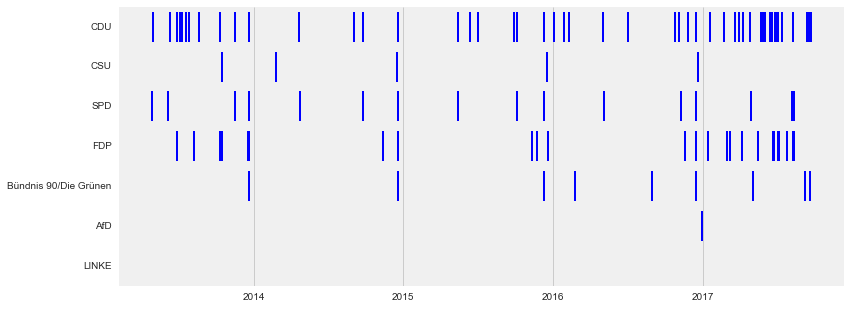

In [13]:
# First preliminary visual analysis, each line equals one major donation
plt.figure(figsize=(13,5))
plt.style.use("fivethirtyeight")
ax = sns.stripplot("date_received", "receiving_party", data = dfbigdonations, order=["CDU", "CSU","SPD", "FDP", "Bündnis 90/Die Grünen", "AfD", "LINKE"], marker="|", linewidth= 2, size=30, color="blue")
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.tick_params(length=0)

Take-aways:
    - Higher frequency of major donations in 2017 election year than in 2013 election year (assumption: maybe also more non-major donations  that we will only learn about in 18 months when the financial statements are released)
    - After the FDP dropped out of parliament, also donations ceased in 2014,2015,2016 - increased frequency in 2017 as a hint that some groups/companies want FDP to return into parliament (which worked out)
    - only one major donation for AFD? That's strange because they don't get state funding and would need to source money from elsewhere
    - would be helpful to know who the donors are and see whether they contribute frequently and/or only to one specific party --> interactive version will provide that

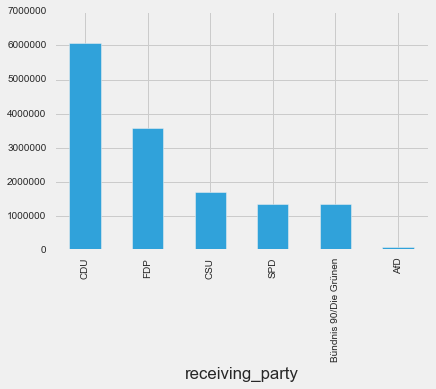

In [14]:
# measured by major donations, which party received how much money since 2013?
dfbigdonations.groupby(by="receiving_party")["amount_donated"].sum().sort_values(ascending=False).plot(kind="bar")

Take-aways:
    - Angela Merkel's CDU/CSU leads by far with donations (in this context in maybe doesn't come as a surprise that they as the only party oppose more transparent party donation laws)
    - FDP as a "business party" ranking second comes as no surprise
    - interesting though that SPD and Gruene (Greens, ecological focus) are almost same level, since the SPD (social democrats) has way more support in the voting population

# Data source 2: Parties' financial statements

## Reverse engineering pdfs into machine-readable files for 2014 and 2015 accounts of all six parties

Source: http://www.bundestag.de/parlament/praesidium/parteienfinanzierung/rechenschaftsberichte/

Whole reports were downloaded and separated into one pdf for each party that only held the relevant information: The list of donors who made a contribution larger than 10k a year, with their name, address and total amount donated



In [15]:
import glob

In [16]:
# !tesseract --list-langs

List of available languages (107):
afr
amh
ara
asm
aze
aze_cyrl
bel
ben
bod
bos
bul
cat
ceb
ces
chi_sim
chi_tra
chr
cym
dan
dan_frak
deu
deu_frak
dzo
ell
eng
enm
epo
equ
est
eus
fas
fin
fra
frk
frm
gle
glg
grc
guj
hat
heb
hin
hrv
hun
iku
ind
isl
ita
ita_old
jav
jpn
kan
kat
kat_old
kaz
khm
kir
kor
kur
lao
lat
lav
lit
mal
mar
mkd
mlt
msa
mya
nep
nld
nor
ori
osd
pan
pol
por
pus
ron
rus
san
sin
slk
slk_frak
slv
spa
spa_old
sqi
srp
srp_latn
swa
swe
syr
tam
tel
tgk
tgl
tha
tir
tur
uig
ukr
urd
uzb
uzb_cyrl
vie
yid

In [17]:
#Convert all pdfs to images so tesseract can read them
years_list=[2014,2015]

party_list=["CDU", "SPD", "GRUENE", "CSU", "LINKE", "FDP", "AFD"]

for year in years_list:
    for party in party_list:
        filename = 'data/financial_statements_tesseract_coverted/output' + party + str(year)

        !mkdir {filename}

        !convert -density 300 data/financial_statement_pdfs/rechenschaftsbericht_{year}_{party}.pdf {filename}/output.png
        
        #convert images to text files with tesseract
        pages = glob.glob(filename+'/*.png')

        for page in pages:
            !tesseract {page} {page[:-4]} -l deu -c tessedit_char_blacklist=ﬁﬂ

Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract Open Source OCR Engine v3.05.01 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Tesseract 

In [40]:
# Next step: manually clean and double check all ocr-ed information, since tesseract despite the German language libraries has trouble with letters like ö,ä,ü,ß and the distinction of a capital i and small L 
# and compile a csv that contains all donations to all parties in 2015 and 2014 with help of a lot of Regular Expressions

## Combine 2013 from Open Data City and the newly harvested from 2014 and 2015

In [41]:
# for all new dfs check donation amount with .isnull() and correct NaN mistakes (wrong commas etc) manually in dataset

### 2013 data

2013 data was taken from here https://apps.opendatacity.de/parteispenden-recherche/#/list
    
They claim to have data for 2014 too, but it's only a few entries. 
After coming across a few duplicates, I checked all entries against the original pdfs

In [18]:
df2013 = pd.read_csv("data/2013_donations-by-opendatacity-corrected.csv", encoding ="latin-1", delimiter =";")

In [19]:
df2013.head()

,Jahr,Name,Straße,Postleitzahl,Stadt,Partei,Typ,Betrag
0,2013,ALBA Group plc & Co. KG,Knesebeckstraße 56-58,10719,Berlin,CDU,jur,20000.00
1,2013,ANKA-Draht Insinger KG,Industriestraße 7,92431,Neunburg vorm Wald,CSU,jur,10500.00
2,2013,Daniel Andreas Lede Abal,Höhbergstraße 25,72074,Tübingen,GRUENE,nat,10694.88
3,2013,Martin-Sebastian Abel,Beethovenstraße 10,40233,Düsseldorf,GRUENE,nat,15865.19
4,2013,Accon Köln GmbH,Friedrich-Karl-Straße 241-243,50735,Köln,SPD,jur,15000.00


In [20]:
# Checking for duplicates for year party and deleting them manually from csv
pd.set_option("display.max_rows", 300)
df2013[df2013["Partei"]=="GRUENE"].head()

,Jahr,Name,Straße,Postleitzahl,Stadt,Partei,Typ,Betrag
2,2013,Daniel Andreas Lede Abal,Höhbergstraße 25,72074,Tübingen,GRUENE,nat,10694.88
3,2013,Martin-Sebastian Abel,Beethovenstraße 10,40233,Düsseldorf,GRUENE,nat,15865.19
12,2013,Tarek Al-Wazir,Rohrstraße 82,63075,Offenbach,GRUENE,nat,15920.00
14,2013,Jan Philipp Albrecht,Hospitalstraße 2,22767,Hamburg,GRUENE,nat,18124.92
21,2013,Allianz SE,Pariser Platz 6,10117,Berlin,GRUENE,jur,30000.00


In [21]:
# inspecting data type
df2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
Jahr            1059 non-null int64
Name            1059 non-null object
Straße          1059 non-null object
Postleitzahl    1059 non-null object
Stadt           1059 non-null object
Partei          1059 non-null object
Typ             1059 non-null object
Betrag          1059 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 66.3+ KB


In [22]:
df2013["Partei"].value_counts()

CDU       281
GRUENE    246
SPD       197
CSU       116
FDP       103
LINKE     101
AFD        15
Name: Partei, dtype: int64

In [23]:
#EDITS to do:
#Convert Jahr into datetime
#Join PLZ & Stadt
#drop Typ
#unify party names

In [24]:
datetime.strptime(str(df2013["Jahr"][0]), "%Y")

datetime.datetime(2013, 1, 1, 0, 0)

In [25]:
df2013["year"]=[datetime.strptime(str(value), "%Y") for value in df2013["Jahr"]]

In [26]:
# joining ZIP code and city into address line 2
df2013["Address_line2"]=df2013["Postleitzahl"].astype(str)+" "+df2013["Stadt"]

In [27]:
# joining street name with address line 2
df2013["Address"]=df2013["Straße"]+", "+df2013["Address_line2"]

In [28]:
# rearranging structure of the df
df2013=df2013[["year","Partei","Name","Address","Betrag"]]

In [29]:
df2013.head()

,year,Partei,Name,Address,Betrag
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00


In [30]:
# renaming columns
df2013.columns=(['year_parsed', 'receiving_party', 'donor_name', 'Address', 'donation'])

In [31]:
df2013.head()

,year_parsed,receiving_party,donor_name,Address,donation
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00


### 2014 Data

In [32]:
df2014=pd.read_csv("data/2014_donations.csv")

In [33]:
df2014.head()

,year,receiving_party,donor_name,Address_line1,Address_line2,amount_donated
0,2014,CDU,ADIB Agrar- Dienstleistungs- Industrie- und Ba...,Bahnhofstraße 10,99947 Bad Langensalza,13500.00
1,2014,CDU,Aesculap AG,Am Aesculap-Platz,78532 Tuttlingen,15000.00
2,2014,CDU,Allfinanz Deutsche Vermögensberatung Aktienges...,Münchener Straße 1,60329 Frankfurt am Main,30000.00
3,2014,CDU,Allianz SE,Königinstraße 28,80802 München,30000.00
4,2014,CDU,Arbeitgeberverband der Metall- und Elektroindu...,Staberger Straße 5,58511 Lüdenscheid,25000.00


In [34]:
df2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 6 columns):
year               911 non-null int64
receiving_party    911 non-null object
donor_name         911 non-null object
Address_line1      911 non-null object
Address_line2      911 non-null object
amount_donated     911 non-null object
dtypes: int64(1), object(5)
memory usage: 42.8+ KB


In [35]:
df2014["year_parsed"]=[datetime.strptime(str(value), "%Y") for value in df2014["year"]]

In [36]:
df2014["donation"]=df2014["amount_donated"].apply(float_conversion)

In [37]:
df2014["Address"]=df2014["Address_line1"]+", "+df2014["Address_line2"]

In [38]:
df2014=df2014[["year_parsed", "receiving_party", "donor_name", "Address","donation"]]

In [39]:
df2014.head()

,year_parsed,receiving_party,donor_name,Address,donation
0,2014-01-01,CDU,ADIB Agrar- Dienstleistungs- Industrie- und Ba...,"Bahnhofstraße 10, 99947 Bad Langensalza",13500.0
1,2014-01-01,CDU,Aesculap AG,"Am Aesculap-Platz, 78532 Tuttlingen",15000.0
2,2014-01-01,CDU,Allfinanz Deutsche Vermögensberatung Aktienges...,"Münchener Straße 1, 60329 Frankfurt am Main",30000.0
3,2014-01-01,CDU,Allianz SE,"Königinstraße 28, 80802 München",30000.0
4,2014-01-01,CDU,Arbeitgeberverband der Metall- und Elektroindu...,"Staberger Straße 5, 58511 Lüdenscheid",25000.0


### 2015 data

In [40]:
df2015=pd.read_csv("data/2015_donations.csv")

In [41]:
df2015.head()

,year,receiving_party,donor_name,Address_line1,Address_line2,amount_donated
0,2015,CDU,Adolf Würth GmbH & Co. KG,Reinhold-Würth-Straße 12-17,74653 Künzelsau-Gaisbach,11500.00
1,2015,CDU,Allfinanz Deutsche Vermögensberatung AG,Münchener Straße 1,60329 Frankfurt am Main,40000.00
2,2015,CDU,Allianz Deutschland AG,Königinstraße 28,80802 München,30000.00
3,2015,CDU,Aluminium Rheinfelden GmbH,Friedrichstraße 80,79618 Rheinfelden,23000.00
4,2015,CDU,Arbeitgeberverband der Metall- und Elektroindu...,Staberger Straße 5,58511 Lüdenscheid,22000.00


In [42]:
df2015["donation"]=df2015["amount_donated"].apply(float_conversion)

In [43]:
df2015["year_parsed"]=[datetime.strptime(str(value), "%Y") for value in df2015["year"]]

In [44]:
df2015["Address"]=df2015["Address_line1"]+", "+df2015["Address_line2"]

In [45]:
df2015=df2015[["year_parsed", "receiving_party", "donor_name", "Address","donation"]]

### join datasets for 2013, 2014, 2015 into one

In [46]:
df2013_15 = df2013.copy()

In [47]:
df2013_15 = df2013_15.append(df2014)

In [48]:
df2013_15 = df2013_15.append(df2015)

In [49]:
df2013_15["year_parsed"].value_counts()

2013-01-01    1059
2014-01-01     911
2015-01-01     876
Name: year_parsed, dtype: int64

In [50]:
df2013_15.head()

,year_parsed,receiving_party,donor_name,Address,donation
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00


In [51]:
df2013_15["year_parsed"].value_counts()

2013-01-01    1059
2014-01-01     911
2015-01-01     876
Name: year_parsed, dtype: int64

In [52]:
df2013_15["receiving_party"].value_counts()

GRUENE    739
CDU       661
SPD       624
LINKE     308
CSU       289
FDP       194
AFD        30
SDP         1
Name: receiving_party, dtype: int64

In [53]:
df2013_15["type"]="r"

In [54]:
df2013_15.head()

,year_parsed,receiving_party,donor_name,Address,donation,type
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r


In [55]:
# save as a csv and run through open refine to unify information on names and addresses

# df2013_15.to_csv("2013to2015donation-2017-09-06.csv")

In [57]:
# loading refined dataset
dfalldonations1315 = pd.read_csv("data/2013to2015donation_2017-09-06-cleaned-refined.csv")

In [58]:
# inspect data type
dfalldonations1315.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846 entries, 0 to 2845
Data columns (total 6 columns):
year_parsed        2846 non-null object
receiving_party    2846 non-null object
donor_name         2846 non-null object
Address            2846 non-null object
donation           2839 non-null float64
type               2846 non-null object
dtypes: float64(1), object(5)
memory usage: 133.5+ KB


In [59]:
#check datetime conversion
datetime.strptime(str(dfalldonations1315["year_parsed"][0]), "%Y-%m-%d")

datetime.datetime(2013, 1, 1, 0, 0)

In [60]:
#convert all year information into year-mm-dd format with mm-dd being 01-01 for all (date donation was made not provided, only the year)
dfalldonations1315["year_parsed"]=[datetime.strptime(str(value), "%Y-%m-%d") for value in dfalldonations1315["year_parsed"]]

In [61]:
dfalldonations1315.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846 entries, 0 to 2845
Data columns (total 6 columns):
year_parsed        2846 non-null datetime64[ns]
receiving_party    2846 non-null object
donor_name         2846 non-null object
Address            2846 non-null object
donation           2839 non-null float64
type               2846 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 133.5+ KB


### Donations received between 2013 and 2015

In [62]:
dfalldonations1315.groupby("receiving_party")["donation"].sum().sort_values(ascending=False)

receiving_party
CDU       15858797.56
GRUENE    11753939.66
SPD        9765290.66
CSU        6698459.00
FDP        5838648.33
LINKE      4736764.45
AFD         643015.76
SDP          10540.00
Name: donation, dtype: float64

Between 2013 and 2015 parties received donations of:

CDU 16 million euros documented with donor name -- plus 60 million euros with donor unknown

GRUENE 12 million euros documented with donor name -- plus 2 million euros with donor unknown

SPD 10 million euros documented with donor name -- plus 30 million euros with donor unknown

CSU 7 million euros documented with donor name -- plus 27 million euros with donor unknown

FDP 6 million euros documented with donor name -- plus 20 million euros with donor unknown

LINKE 5 million euros documented with donor name -- plus 2 million euros with donor unknown

AFD 643,000 euros


### Who donated to far-right AFD?

In [64]:
dfalldonations1315[dfalldonations1315["receiving_party"]=="AFD"]

,year_parsed,receiving_party,donor_name,Address,donation,type
13,2013-01-01,AFD,Dr. Carsten Albers,"Mulackstraße 12, 10119 Berlin",13000.00,r
194,2013-01-01,AFD,Christian Duus,"Rigistraße 5, CH-08703 Erlenbach",10500.00,r
214,2013-01-01,AFD,Erika Edler,"Elbchaussee 255, 22605 Hamburg",50000.00,r
215,2013-01-01,AFD,Dr. Folkard Edler,"Elbchaussee 255, 22605 Hamburg",50000.00,r
258,2013-01-01,AFD,Hellmut Fölster,"Weinhardstraße 9, 82211 Herrsching am Ammersee",13687.85,r
362,2013-01-01,AFD,Gottfried Heller,"Straßberger Straße 30, 80809 München",12000.00,r
438,2013-01-01,AFD,Dr. Uwe Kaack,"Bülowstraße 16, 24105 Kiel",11250.00,r
564,2013-01-01,AFD,Horst Lieberwirth,"Turm 2, 17252 Roggentin",11750.00,r
746,2013-01-01,AFD,Günter Reimer,"Richard-Wagner-Straße 6, 65812 Bad Soden am Ta...",13400.00,r
764,2013-01-01,AFD,Johannes Ross,"Buchbergweg 10, 83703 Gmund am Tegernsee",17389.49,r


## Comparing donations of 50k plus between data source 1 (designated publication website for major donations)  and data source 2 (parties' financial statements)

type r = Rechenschaftsbericht = party's financial statement

type g = Grossspende = major donation

Each of the following tables was printed out and compared data source 1 against data source 2 for each party. In case a donation was listed in source 1 it was crossed out manually in source 2, leaving those who made a contribution of 50k euros or higher without a declared major donation.

*Note: There's certainly a way to have this done by the computer, however based on the factors of time we chose this rather old-fashioned way which certainly makes it more difficult to reproduce*

### CDU

In [65]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="CDU")&(dfalldonations1315["donation"]>=50000)]

,year_parsed,receiving_party,donor_name,Address,donation,type
15,2013-01-01,CDU,Allfinanz Deutsche Vermögensberatung AG,"Münchener Straße 1, 60329 Frankfurt am Main",80000.0,r
37,2013-01-01,CDU,August Storck KG,"Waldstraße 27, 13403 Berlin",50000.0,r
133,2013-01-01,CDU,Dietmar Bücher,"Veitenmühlweg 2, 65510 Idstein",73000.0,r
149,2013-01-01,CDU,Daimler AG,"Mercedesstraße 137, 70546 Stuttgart",100000.0,r
163,2013-01-01,CDU,Deutsche Vermögensberatung AG,"Münchener Straße 1, 60329 Frankfurt am Main",143000.0,r
166,2013-01-01,CDU,Deutsche Vermögensberatung Holding GmbH,"Rosenstraße 28, 35037 Marburg",90000.0,r
177,2013-01-01,CDU,Dr. August Oetker KG,"Lutterstraße 14, 33617 Bielefeld",78000.0,r
227,2013-01-01,CDU,Evonik Industries AG,"Rellinghauser Straße 1-11, 45128 Essen",70000.0,r
262,2013-01-01,CDU,GB Immobilien GmbH,"Heegbarg 30, 22391 Hamburg",50000.0,r
350,2013-01-01,CDU,HeidelbergCement AG,"Berliner Straße 6, 69120 Heidelberg",50000.0,r


In [66]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="CDU")&(dfalldonations1315["donation"]>50000.00)]["donation"].count()
# The CDU received 45 donations above 50k according to their financial statements (source 2)

45

In [67]:
dfbigdonations[(dfbigdonations["receiving_party"]=="CDU")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
0,150000.0,2013-12-20,2014-01-07,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,CDU,[Drs. 18/335],g
5,70000.0,2013-11-15,2013-11-19,"Rellinghauser Straße 1 - 11, 45128 Essen",Evonik Industries AG,CDU,[Drs. 18/151],g
12,230000.0,2013-10-09,2013-10-10,"Seedammweg 55, 61352 Bad Homburg",Susanne Klatten,CDU,[Drs. 17/14829],g
13,230000.0,2013-10-09,2013-10-10,"Seedammweg 55, 61352 Bad Homburg",Johanna Quandt,CDU,[Drs. 17/14829],g
14,230000.0,2013-10-09,2013-10-10,"Seedammweg 55, 61352 Bad Homburg",Stefan Quandt,CDU,[Drs. 17/14829],g
15,60000.0,2013-06-27,2013-08-29,"Uerdinger Straße 58 - 62, 40474 Düsseldorf",METALL NRW Verband der Metall- und Elektro-Ind...,CDU,[Drs. 17/14778],g
16,60000.0,2013-08-19,2013-08-23,"Erich-Nörrenberg-Straße 1, 58636 Iserlohn",Märkischer Arbeitgeberverband e.V.,CDU,[Drs. 17/14709],g
18,100000.0,2013-07-26,2013-08-08,"Mainzer Landstraße 55, 60329 Frankfurt am Main",Verband der Chemischen Industrie e.V. (VCI),CDU,[Drs. 17/14625],g
20,130000.0,2013-07-18,2013-07-25,"Merckstraße 40, 64342 Seeheim-Jugenheim",Prof. Dr. Hans-Joachim Langmann,CDU,[Drs. 17/14625],g
21,70000.0,2013-07-09,2013-07-11,"Waldweg 9, 77963 Schwanau",Dr. Ing. E.h. Martin Herrenknecht,CDU,[Drs. 17/14442],g


In [68]:
dfbigdonations[(dfbigdonations["receiving_party"]=="CDU")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The CDU received 23 donations above 50k according to the major donations website (source 1)

23

### CSU

In [69]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="CSU")&(dfalldonations1315["donation"]>=50000.00)]

,year_parsed,receiving_party,donor_name,Address,donation,type
60,2013-01-01,CSU,BayWa AG,"Arabellastraße 4, 81925 München",59650.0,r
801,2013-01-01,CSU,Henriette Schmidt-Burkhardt,"An der Schwedenschanze 11, 90455 Nürnberg",50000.0,r
913,2013-01-01,CSU,Südzucker AG,"Theodor-Heuss-Anlage 12, 68165 Mannheim",70000.0,r
959,2013-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",642332.5,r
972,2013-01-01,CSU,Verein der Bayerischen Chemischen Industrie e.V.,"Innstraße 15, 81679 München",149000.0,r
1806,2014-01-01,CSU,Klaus GmbH & Co. KG,"Schwangaustraße 29, 86163 Augsburg",51000.0,r
1816,2014-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph—Straße 5, 80333 München",333000.0,r
1818,2014-01-01,CSU,Verein der Bayerischen Chemischen Industrie e.V.,"Innstraße 15, 81679 München",75500.0,r
2774,2015-01-01,CSU,Schatt Holding GmbH,"Walter-Schatt-Allee 1-3, 83101 Thansau",50000.0,r
2788,2015-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",370000.0,r


In [70]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="CSU")&(dfalldonations1315["donation"]>50000.00)]["donation"].count()
# The CSU received 9 donations above 50k according to their financial statements (source 2)

9

In [71]:
dfbigdonations[(dfbigdonations["receiving_party"]=="CSU")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
11,565000.00,2013-10-15,2013-10-17,"Max-Joseph-Straße 5, 80333 München",Verband der Bayerischen Metall- und Elektroind...,CSU,[Drs. 18/22],g
35,300000.00,2014-12-17,2014-12-19,"Max-Joseph-Str. 5, 80333 München",Verband der Bayerischen Metall- und Elektro- I...,CSU,[Drs. 18/3757],g
43,143371.27,2014-02-25,2014-02-26,"Petuelring 130, 80788 München",Bayerische Motoren Werke AG,CSU,[Drs. 18/1406],g
45,358000.00,2015-12-18,2015-12-21,"Max-Joseph-Straße 5, 80333 München",Verband der Bayerischen Metall- und Elektroind...,CSU,[Drs. 18/7280],g


In [72]:
dfbigdonations[(dfbigdonations["receiving_party"]=="CSU")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The CSU received 5 donations above 50k according to the major donations website (source 1)

4

### SPD

In [73]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="SPD")&(dfalldonations1315["donation"]>=50000.00)]

,year_parsed,receiving_party,donor_name,Address,donation,type
153,2013-01-01,SPD,Daimler AG,"Mercedesstraße 137, 70546 Stuttgart",100000.0,r
231,2013-01-01,SPD,Evonik Industries AG,"Reliinghauser Straße 1-11, 45128 Essen",90000.0,r
911,2013-01-01,SPD,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",55000.0,r
916,2013-01-01,SPD,Südzucker AG,"Theodor-Heuss-Anlage 12, 68165 Mannheim",51000.0,r
917,2013-01-01,SPD,Marga Süsselbeck,"An der Lister Kirche 2, 30163 Hannover",83000.0,r
962,2013-01-01,SPD,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",50000.0,r
967,2013-01-01,SPD,Verband der Chemischen Industrie e.V.,"Mainzer Landstraße 55, 60329 Frankfurt am Main",85000.0,r
1293,2014-01-01,SPD,CPO Hanser Service GmbH,"Paulsborner Str. 44, 14193 Berlin",60000.0,r
1296,2014-01-01,SPD,Daimler AG,"Mercedesstraße 137, 70546 Stuttgart",100000.0,r
1310,2014-01-01,SPD,Evonik Industries AG,"Rellinghauser Straße 1-11, 45128 Essen",90000.0,r


In [74]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="SPD")&(dfalldonations1315["donation"]>50000.00)]["donation"].count()
# The SPD received 15 donations above 50k according to their financial statements (source 2)

15

In [75]:
dfbigdonations[(dfbigdonations["receiving_party"]=="SPD")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
1,55000.0,2013-12-20,2013-12-24,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,SPD,[Drs. 18/335],g
6,90000.0,2013-11-15,2013-11-18,"Rellinghauser Straße 1 - 11, 45128 Essen",Evonik Industries AG,SPD,[Drs. 18/151],g
23,80000.0,2013-06-06,2013-07-01,"An der Lister Kirche 2, 30163 Hannover",Marga Süsselbeck,SPD,[Drs. 17/14388],g
27,100000.0,2013-04-26,2013-04-26,"70546 Stuttgart, 20354 Hamburg",Daimler AG,SPD,[Drs. 17/13669],g
31,55000.0,2014-12-18,2014-12-19,Verband der Metall- und Elektroindustrie Baden...,Südwestmetall,SPD,[Drs. 18/3757],g
39,90000.0,2014-09-24,2014-09-24,"Rellinghauser Straße 1 -11, 45128 Essen",Evonik Industries AG,SPD,[Drs. 18/2941],g
41,100000.0,2014-04-23,2014-04-24,"70546 Stuttgart, 40474 Düsseldorf",Daimler AG,SPD,[Drs. 18/1406],g
46,60000.0,2015-12-11,2015-12-16,"Löffelstraße 22-24, 70597 Stuttgart","Südwestmetall, Verband der Metall- und Elektro...",SPD,[Drs. 18/7280],g
53,60000.0,2015-10-06,2015-10-07,"Rellinghauser Straße 1- 11, 45128 Essen",Evonik Industries AG,SPD,[Drs. 18/6472],g
58,100000.0,2015-05-14,2015-05-15,"70546 Stuttgart, 64342 Seeheim-Jugenheim",Daimler AG,SPD,[Drs. 18/5059],g


In [76]:
dfbigdonations[(dfbigdonations["receiving_party"]=="SPD")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The SPD received 11 donations above 50k according to the major donations website (source 1)

10

### FDP

In [77]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="FDP")&(dfalldonations1315["donation"]>=50000.00)]

,year_parsed,receiving_party,donor_name,Address,donation,type
9,2013-01-01,FDP,Dirk Ahlers,"Theodorstraße 42-90/4, 22761 Hamburg",59100.0,r
164,2013-01-01,FDP,Deutsche Vermögensberatung AG,"Münchener Straße 1, 60329 Frankfurt am Main",63000.0,r
229,2013-01-01,FDP,Evonik Industries AG,"Rellinghauser Straße 1-11, 45128 Essen",50000.0,r
354,2013-01-01,FDP,Heinrich Ernst Eugen Heineke,"Kottenstraße 13/14, 33154 Salzkotten",66450.0,r
371,2013-01-01,FDP,Hermes Arzneimittel GmbH,"Georg-Kalb-Straße 5, 82049 Pullach im Isartal",50000.0,r
476,2013-01-01,FDP,Susanne Klatten,"Seedammweg 55, 61352 Bad Homburg vor der Höhe",70000.0,r
644,2013-01-01,FDP,Märkischer Arbeitgeberverband e.V.,"Erich-Nörrenberg-Straße 1, 58595 Iserlohn",53000.0,r
715,2013-01-01,FDP,Prof. Dr. Reinfried Pohl,"Gottfried-Keller-Straße 14, 35039 Marburg",90000.0,r
729,2013-01-01,FDP,Johanna Quandt,"Seedammweg 55, 61352 Bad Homburg vor der Höhe",70000.0,r
731,2013-01-01,FDP,Stefan Quandt,"Seedammweg 55, 61352 Bad Homburg vor der Höhe",70000.0,r


In [78]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="FDP")&(dfalldonations1315["donation"]>50000.00)]["donation"].count()
# The FDP received 22 donations above 50k according to their financial statements (source 2)

22

In [79]:
dfbigdonations[(dfbigdonations["receiving_party"]=="FDP")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
3,80000.0,2013-12-20,2013-12-20,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,FDP,[Drs. 18/335],g
4,200000.0,2013-12-17,2013-12-18,"Lindenallee 78, 50968 Köln",R&W Industriebeteiligungen GmbH,FDP,[Drs. 18/335],g
7,150000.0,2013-10-16,2013-10-23,"Max-Joseph-Straße 5, 80333 München",Verband der Bayerischen Metall- und Elektroind...,FDP,[Drs. 18/42],g
8,70000.0,2013-10-09,2013-10-23,"Günther Quandt-Haus, Seedammweg 55",Susanne Klatten,FDP,[Drs. 18/42],g
9,70000.0,2013-10-09,2013-10-23,"Günther Quandt-Haus, Seedammweg 55",Johanna Quandt,FDP,[Drs. 18/42],g
10,70000.0,2013-10-09,2013-10-23,"Günther Quandt-Haus, Seedammweg 55",Stefan Quandt,FDP,[Drs. 18/42],g
17,64000.0,2013-08-08,2013-08-15,"Mainzer Landstraße 55, 60329 Frankfurt am Main",Verband der Chemischen Industrie e.V. (VCI),FDP,[Drs. 17/14709],g
24,60000.0,2013-06-27,2013-06-28,"Uerdinger Straße 58-62, 40474 Düsseldorf",METALL NRW Verband der Metall- und Elektroindu...,FDP,[Drs. 17/14388],g
34,80000.0,2014-12-18,2014-12-18,Verband der Metall- und Elektroindustrie Baden...,Südwestmetall,FDP,[Drs. 18/3757],g
37,200000.0,2014-11-13,2014-11-14,"Lindenallee 78, 50968 Köln",Firma R & W Industriebeteiligungen GmbH,FDP,[Drs. 18/3386],g


In [80]:
dfbigdonations[(dfbigdonations["receiving_party"]=="FDP")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The FDP received 14 donations above 50k according to the major donations website (source 1)

13

### GRUENE

In [81]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="GRUENE")&(dfalldonations1315["donation"]>=50000.00)]

,year_parsed,receiving_party,donor_name,Address,donation,type
910,2013-01-01,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",60000.00,r
1562,2014-01-01,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstr. 22—24, 70597 Stuttgart",100000.00,r
2467,2015-01-01,GRUENE,Jens Allerheiligen,"Meterstr. 28, 30169 Hannover",50239.99,r
2689,2015-01-01,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstr. 22-24, 70597 Stuttgart",110000.00,r


In [82]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="GRUENE")&(dfalldonations1315["donation"]>50000.00)]["donation"].count()
# The Greens received 4 donations above 50k according to their financial statements (source 2)

4

In [83]:
dfbigdonations[(dfbigdonations["receiving_party"]=="Bündnis 90/Die Grünen")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type
2,60000.0,2013-12-20,2013-12-20,"Löffelstraße 22 - 24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,Bündnis 90/Die Grünen,[Drs. 18/335],g
32,100000.0,2014-12-18,2014-12-19,Verband der Metall- und Elektroindustrie Baden...,Südwestmetall,Bündnis 90/Die Grünen,[Drs. 18/3757],g
47,110000.0,2015-12-11,2015-12-15,"Löffelstraße 22-24, 70597 Stuttgart","Südwestmetall, Verband der Metall- und Elektro...",Bündnis 90/Die Grünen,[Drs. 18/7280],g


In [84]:
dfbigdonations[(dfbigdonations["receiving_party"]=="Bündnis 90/Die Grünen")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The Greens received 3 donations above 50k according to the major donations website (source 1)

3

### LINKE

In [85]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="LINKE")&(dfalldonations1315["donation"]>50000.00)]

,year_parsed,receiving_party,donor_name,Address,donation,type
973,2013-01-01,LINKE,Verein der Bundestagsfraktion DIE LINKE e.V.,"Kleine Alexanderstraße 28, 10178 Berlin",60000.0,r


In [86]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="LINKE")&(dfalldonations1315["donation"]>=50000.00)]["donation"].count()
# The Left received 1 donation above 50k according to their financial statements (source 2)

1

In [87]:
dfbigdonations[(dfbigdonations["receiving_party"]=="LINKE")&(dfbigdonations["date_received"]<"2016-01-01")]

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type


In [88]:
dfbigdonations[(dfbigdonations["receiving_party"]=="LINKE")&(dfbigdonations["date_received"]<"2016-01-01")]["amount_donated"].count()
# The Left received 0 donations above 50k according to the major donation website (source 1)

0

### AfD

In [89]:
dfalldonations1315[(dfalldonations1315["receiving_party"]=="AFD")&(dfalldonations1315["donation"]>50000.00)]
# The AFD received 1 donation above 50k according to their financial statements (source 2)

,year_parsed,receiving_party,donor_name,Address,donation,type
2842,2015-01-01,AFD,Klaus Nordmann,"Nonnenwerthstr. 63, 50937 Köln",58999.99,r


In [90]:
dfbigdonations[(dfbigdonations["receiving_party"]=="AFD")&(dfbigdonations["date_received"]<"2016-01-01")]
# The AfD received 0 donations above 50k according to the major donation webiste (source 1)

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source,type


## Calculation donation amounts per year & per party

In [94]:
#dfg = datasource 1 (scraped major contribution website) csv ran through open refine

dfg = pd.read_csv("data/donations-50kplus-2013-2017-09-06_cleaned-refined.csv")
dfg.head()

,amount_donated,date_received,date_reported,donor_address,donor_name,receiving_party,source
0,150000.0,2013-12-20,2014-01-07,"Löffelstraße 22-24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,CDU,['Drs. 18/335']
1,55000.0,2013-12-20,2013-12-24,"Löffelstraße 22-24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,SPD,['Drs. 18/335']
2,60000.0,2013-12-20,2013-12-20,"Löffelstraße 22-24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,GRUENE,['Drs. 18/335']
3,80000.0,2013-12-20,2013-12-20,"Löffelstraße 22-24, 70597 Stuttgart",Südwestmetall Verband der Metall- und Elektroi...,FDP,['Drs. 18/335']
4,200000.0,2013-12-17,2013-12-18,"Lindenallee 78, 50968 Köln",R&W Industriebeteiligungen GmbH,FDP,['Drs. 18/335']


In [95]:
dfg[dfg["date_received"]<"2014-01-01"]['amount_donated'].sum()

3344000.0

2013: 3.3 million euros major donations

In [97]:
dfg[(dfg["date_received"]>="2014-01-01")&(dfg["date_received"]<"2015-01-01")]['amount_donated'].sum()

1443371.27

2014: 1.4 million euros major donations

In [98]:
dfg[(dfg["date_received"]>="2015-01-01")&(dfg["date_received"]<"2016-01-01")]['amount_donated'].sum()

1818000.0

2015: 1.8 million euros major donations

In [99]:
dfg[(dfg["date_received"]>="2016-01-01")&(dfg["date_received"]<"2017-01-01")]['amount_donated'].sum()

2795991.0

2016: 2.8 million euros major donations

In [100]:
dfg[dfg["date_received"]>="2017-01-01"]['amount_donated'].sum()

4208049.0

2017: 4.2 million euros major donations - cross reference to above stripplot: in fact 0.9 million euros more in 2017 than in 2013

In [104]:
# altering dfg in order to join it with second dataframe of datasource 2 (financial statements)

dfg["type"]="g"

In [105]:
# changing column order to match dfr
dfg=dfg[["date_received", "receiving_party", "donor_name","donor_address","amount_donated", "type", "date_reported", "source"]]

In [106]:
dfg.head()

,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
0,2013-12-20,CDU,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",150000.0,g,2014-01-07,['Drs. 18/335']
1,2013-12-20,SPD,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",55000.0,g,2013-12-24,['Drs. 18/335']
2,2013-12-20,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",60000.0,g,2013-12-20,['Drs. 18/335']
3,2013-12-20,FDP,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",80000.0,g,2013-12-20,['Drs. 18/335']
4,2013-12-17,FDP,R&W Industriebeteiligungen GmbH,"Lindenallee 78, 50968 Köln",200000.0,g,2013-12-18,['Drs. 18/335']


In [107]:
dfg.columns

Index(['date_received', 'receiving_party', 'donor_name', 'donor_address',
       'amount_donated', 'type', 'date_reported', 'source'],
      dtype='object')

In [108]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 8 columns):
date_received      111 non-null object
receiving_party    111 non-null object
donor_name         111 non-null object
donor_address      111 non-null object
amount_donated     111 non-null float64
type               111 non-null object
date_reported      111 non-null object
source             111 non-null object
dtypes: float64(1), object(7)
memory usage: 7.0+ KB


In [120]:
#dfr = dfalldonations1315 = datasource 2 (financial statement pdfs) csv ran through open refine

dfr = pd.read_csv("data/2013to2015donation_2017-09-06-cleaned-refined.csv")
dfr.head()

,year_parsed,receiving_party,donor_name,Address,donation,type
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r


In [121]:
# add columns to match dfg
dfr['date_reported']=""
dfr['source']=''

In [122]:
dfr.head()

,year_parsed,receiving_party,donor_name,Address,donation,type,date_reported,source
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r,,
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r,,
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r,,
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r,,
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r,,


In [123]:
dfr.columns=(['date_received', 'receiving_party', 'donor_name', 'donor_address',
       'amount_donated', 'type', 'date_reported', 'source'])

In [124]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846 entries, 0 to 2845
Data columns (total 8 columns):
date_received      2846 non-null object
receiving_party    2846 non-null object
donor_name         2846 non-null object
donor_address      2846 non-null object
amount_donated     2839 non-null float64
type               2846 non-null object
date_reported      2846 non-null object
source             2846 non-null object
dtypes: float64(1), object(7)
memory usage: 178.0+ KB


In [125]:
# APPENDING dfg to dfr
dfrg = dfr.copy()

In [126]:
dfrg = dfrg.append(dfg)

In [127]:
dfrg.head()

,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r,,
1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r,,
2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r,,
3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r,,
4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r,,


In [128]:
#checking data types
dfrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 110
Data columns (total 8 columns):
date_received      2957 non-null object
receiving_party    2957 non-null object
donor_name         2957 non-null object
donor_address      2957 non-null object
amount_donated     2950 non-null float64
type               2957 non-null object
date_reported      2957 non-null object
source             2957 non-null object
dtypes: float64(1), object(7)
memory usage: 207.9+ KB


In [129]:
dfrg["receiving_party"].value_counts()

GRUENE    746
CDU       712
SPD       642
LINKE     308
CSU       294
FDP       224
AFD        31
Name: receiving_party, dtype: int64

In [130]:
# saving a backup copy that contains data from both sources
# dfrg.to_csv("data/2013to2017_rg_09-06.csv")

In [131]:
# aggregating donation amounts by party
party_list =["GRUENE", "CDU", "SPD", "LINKE", "CSU", "FDP", "AFD"]

aggregation_by_party = []

for party in party_list:
    party_information ={
        "party": party,
        "all_over10": dfrg[(dfrg["receiving_party"]== party)&(dfrg["type"]=="r")]["amount_donated"].sum(),
        "all_over50": dfrg[(dfrg["receiving_party"]== party)&(dfrg["type"]=="g")]["amount_donated"].sum()
    }
    aggregation_by_party.append(party_information)

In [132]:
aggregation_by_party

[{'all_over10': 11753939.66, 'all_over50': 1079989.0, 'party': 'GRUENE'},
 {'all_over10': 15858797.560000001, 'all_over50': 5761539.0, 'party': 'CDU'},
 {'all_over10': 9775830.6600000001, 'all_over50': 1361000.0, 'party': 'SPD'},
 {'all_over10': 4736764.4500000002, 'all_over50': 0, 'party': 'LINKE'},
 {'all_over10': 6698458.9999999991, 'all_over50': 1716371.27, 'party': 'CSU'},
 {'all_over10': 5838648.3300000001, 'all_over50': 3590512.0, 'party': 'FDP'},
 {'all_over10': 643015.76000000001, 'all_over50': 100000.0, 'party': 'AFD'}]

In [133]:
#aggregating donation amounts by year
year_list = ["2013", "2014", "2015", "2016", "2017"]

aggregation_by_year = []

for year in year_list:
    year_information ={
        "year": year,
        "all_over10": dfrg[(dfrg["date_received"].str.contains(year+"-"))&(dfrg["type"]=="r")]["amount_donated"].sum(),
        "all_over50": dfrg[(dfrg["date_received"].str.contains(year+"-"))&(dfrg["type"]=="g")]["amount_donated"].sum()
    }
    aggregation_by_year.append(year_information)

In [134]:
aggregation_by_year

[{'all_over10': 23159978.509999998, 'all_over50': 3344000.0, 'year': '2013'},
 {'all_over10': 16211800.600000001, 'all_over50': 1443371.27, 'year': '2014'},
 {'all_over10': 15933676.310000001, 'all_over50': 1818000.0, 'year': '2015'},
 {'all_over10': 0, 'all_over50': 2795991.0, 'year': '2016'},
 {'all_over10': 0, 'all_over50': 4208049.0, 'year': '2017'}]

In [135]:
dfp= pd.DataFrame(aggregation_by_party)
dfy= pd.DataFrame(aggregation_by_year)

# saving the csvs to use for d3.js visualisations
# dfp.to_csv("donations_by_party.csv")
# dfy.to_csv("donations_by_year.csv")

# Inquiring about specific donors and their donations to parties

In [137]:
# this part was handed to a reporter so he could also run small checks himself
df_reportercheck = pd.read_csv("data/2013to2017_rg_09-06.csv")

In [138]:
df_reportercheck.head()

,Unnamed: 0,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
0,0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r,NaN,NaN
1,1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r,NaN,NaN
2,2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r,NaN,NaN
3,3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r,NaN,NaN
4,4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r,NaN,NaN


In [139]:
df_reportercheck[df_reportercheck["donor_name"]=="Verband der Bayerischen Metall- und Elektroindustrie e.V."]

,Unnamed: 0,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
959,959,2013-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",642332.5,r,NaN,NaN
960,960,2013-01-01,FDP,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",150000.0,r,NaN,NaN
961,961,2013-01-01,GRUENE,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",35000.0,r,NaN,NaN
962,962,2013-01-01,SPD,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",50000.0,r,NaN,NaN
1390,1390,2014-01-01,SPD,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",50000.0,r,NaN,NaN
1575,1575,2014-01-01,GRUENE,Verband der Bayerischen Metall- und Elektroind...,"Max—Joseph-Str. 5, 50363 München",30000.0,r,NaN,NaN
1816,1816,2014-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph—Straße 5, 80333 München",333000.0,r,NaN,NaN
2324,2324,2015-01-01,SPD,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",50000.0,r,NaN,NaN
2701,2701,2015-01-01,GRUENE,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Str. 5, 80333 München",30000.0,r,NaN,NaN
2788,2788,2015-01-01,CSU,Verband der Bayerischen Metall- und Elektroind...,"Max-Joseph-Straße 5, 80333 München",370000.0,r,NaN,NaN


In [141]:
#2013 to 2015 type r, 2016 and 2017 type g, to avoid duplicates

df_reportercheck_selection = df_reportercheck[(df_reportercheck["type"]=="g")&(df_reportercheck["date_received"]>"2015-12-31")|(df_reportercheck["type"]=="r")]

In [142]:
df_reportercheck_selection.head()

,Unnamed: 0,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
0,0,2013-01-01,CDU,ALBA Group plc & Co. KG,"Knesebeckstraße 56-58, 10719 Berlin",20000.00,r,NaN,NaN
1,1,2013-01-01,CSU,ANKA-Draht Insinger KG,"Industriestraße 7, 92431 Neunburg vorm Wald",10500.00,r,NaN,NaN
2,2,2013-01-01,GRUENE,Daniel Andreas Lede Abal,"Höhbergstraße 25, 72074 Tübingen",10694.88,r,NaN,NaN
3,3,2013-01-01,GRUENE,Martin-Sebastian Abel,"Beethovenstraße 10, 40233 Düsseldorf",15865.19,r,NaN,NaN
4,4,2013-01-01,SPD,Accon Köln GmbH,"Friedrich-Karl-Straße 241-243, 50735 Köln",15000.00,r,NaN,NaN


## Top100 most frequent donors

In [144]:
df_reportercheck_selection["donor_name"].value_counts(ascending= False).head(100)

Daimler AG                                                                       19
Evonik Industries AG                                                             16
Südwestmetall Verband der Metall- und Elektroindustrie Baden-Württemberg e.V.    16
ERGO Versicherungsgruppe AG                                                      15
Münchener Rückversicherungsgesellschaft AG                                       15
Allianz SE                                                                       15
Verband der Chemischen Industrie e.V.                                            14
Verband der Bayerischen Metall- und Elektroindustrie e.V.                        12
Philip Morris GmbH                                                               12
Gauselmann AG                                                                    11
Verband der Metall- und Elektroindustrie Nordrhein-Westfalen e.V.                 9
Dr. August Oetker KG                                                        

## Top100 donors who gave most money

In [145]:
df_reportercheck_selection.groupby("donor_name")["amount_donated"].sum().sort_values(ascending=False).head(100)

donor_name
Verband der Bayerischen Metall- und Elektroindustrie e.V.                        2140332.50
Südwestmetall Verband der Metall- und Elektroindustrie Baden-Württemberg e.V.    1591000.00
Daimler AG                                                                       1360000.00
R&W Industriebeteiligungen GmbH                                                  1056310.00
Evonik Industries AG                                                              920000.00
Prof. Dr. Hans-Joachim Langmann                                                   810000.00
Verband der Chemischen Industrie e.V.                                             703500.00
Deutsche Vermögensberatung AG                                                     689500.00
Jochen Wermuth                                                                    599989.00
Ralph Dommermuth                                                                  540000.00
Dr. Lutz Helmig                                                      

## Check which party received what amount from a selected donor

In [146]:
selected_donor = "Südwestmetall Verband der Metall- und Elektroindustrie Baden-Württemberg e.V."
df_reportercheck_selection[df_reportercheck_selection['donor_name']==selected_donor].groupby("receiving_party")["amount_donated"].sum()

receiving_party
CDU       606000.0
FDP       375000.0
GRUENE    380000.0
SPD       230000.0
Name: amount_donated, dtype: float64

## Check for single donations of that selected donor

In [147]:
df_reportercheck_selection[df_reportercheck_selection['donor_name']==selected_donor]

,Unnamed: 0,date_received,receiving_party,donor_name,donor_address,amount_donated,type,date_reported,source
908,908,2013-01-01,CDU,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",155000.0,r,NaN,NaN
909,909,2013-01-01,FDP,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",80000.0,r,NaN,NaN
910,910,2013-01-01,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",60000.0,r,NaN,NaN
911,911,2013-01-01,SPD,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",55000.0,r,NaN,NaN
1243,1243,2014-01-01,CDU,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",150500.0,r,NaN,NaN
1382,1382,2014-01-01,SPD,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",55000.0,r,NaN,NaN
1562,1562,2014-01-01,GRUENE,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstr. 22—24, 70597 Stuttgart",100000.0,r,NaN,NaN
1954,1954,2014-01-01,FDP,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstr. 22-24, 70597 Stuttgart",80000.0,r,NaN,NaN
2116,2116,2015-01-01,CDU,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",150500.0,r,NaN,NaN
2312,2312,2015-01-01,SPD,Südwestmetall Verband der Metall- und Elektroi...,"Löffelstraße 22-24, 70597 Stuttgart",60000.0,r,NaN,NaN


# Gathering data for mobile-version visuals

In [149]:
df_reportercheck_selection[(df_reportercheck_selection["receiving_party"]=="CDU")&(df_reportercheck_selection["date_received"]>="2013-01-01")&(df_reportercheck_selection["date_received"]<"2014-01-01")].groupby("date_received")["amount_donated"].sum()

date_received
2013-01-01    8248915.6
Name: amount_donated, dtype: float64

In [150]:
dfg[(dfg["receiving_party"]=="CDU")&(dfg["date_received"]>="2016-01-01")&(dfg["date_received"]<"2017-01-01")]["amount_donated"].sum()

1025002.0

In [152]:
# compiling data for chart 2, mobile version
dfc2=pd.read_csv("data/data-chart2-mobile.csv")

In [153]:
dfc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
party            35 non-null object
year             35 non-null int64
all_donations    35 non-null float64
grossspende      34 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ KB


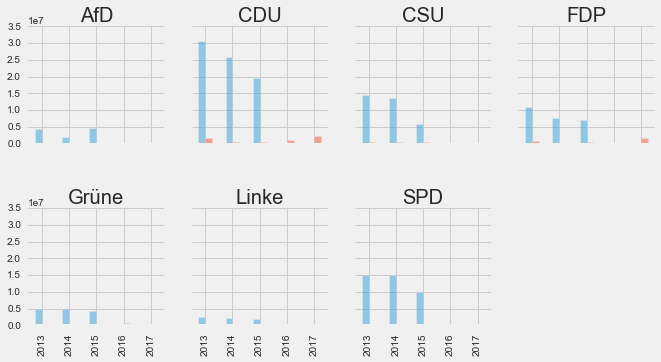

In [154]:
df=dfc2.copy()
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,5))
axes_list = [item for sublist in axes for item in sublist]

parties = (["CDU", "CSU", "SPD", "Linke", "Grüne", "FDP", "AfD"])

subset_df = df[df['party'].isin(parties)]

for partyname, selection in subset_df.groupby('party'):
    ax = axes_list.pop(0)
    selection.plot(kind="bar", x="year", label=partyname, ax=ax, legend=False, alpha=0.5)
    ax.set_title(partyname)
    ax.set_ylim(0,35000000)
    ax.tick_params(
        which='minor',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.tick_params(
        which='major',
        bottom='on',
        left='off',
        right='off',
        top='off'
    )
    #ax.grid(linewidth=0.25)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("")

for ax in axes_list:
    ax.remove()

plt.subplots_adjust(hspace=0.55)

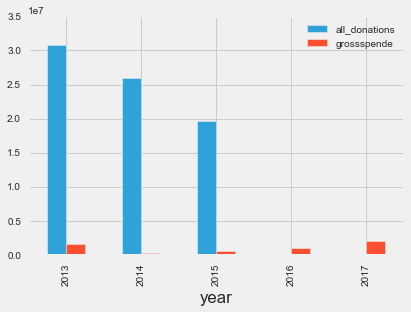

In [155]:
#downloading bar plot for each party
dfc2[dfc2["party"]=="CDU"].plot(kind="bar", x="year")
# plt.savefig("Chart-2-mobile-CDU.pdf", transparent=True)